In [1]:
#GET DATASET
#MAKE IT BIGGER
#GET COORDINATES FOR POINTS
#MODEL TRAINED TO GET 4 POINTS
#CONCLUSE ANGLES BASED ON THOSE POINTS


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
folp = "/content/drive/MyDrive/est/img"
jolp = "/content/drive/MyDrive/est/json"

afolp = "/content/drive/MyDrive/aest/img"
ajolp = "/content/drive/MyDrive/aest/json"
acolp = "/content/drive/MyDrive/aest/cimg"



In [7]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import copy


In [ ]:
def flip_image_horizontal(img):
    transform = transforms.functional.hflip
    flipped_img = transform(img)
    return flipped_img


def resize_and_crop_image(image_path, increment):
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img.size[1], img.size[0] + increment)),  # Resize width only
        transforms.CenterCrop((img.size[1], img.size[0])),  # Crop to original size
    ])
    resized_and_cropped_img = transform(img)
    return resized_and_cropped_img

def flip_image_horizontal_tensor(img_tensor):
    return torch.flip(img_tensor, dims=[3])

def resize_and_crop_image_tensor(img_tensor, increment):
    print(img_tensor.size())
    batch_size ,num_channels, height, width  = img_tensor.size()
    new_width = width + increment

    # Resize along the width dimension
    resized_tensor = torch.nn.functional.interpolate(img_tensor, size=(height, new_width), mode='bilinear')

    # Calculate cropping range for original width
    crop_start = 0
    crop_end = width

    if increment > 0:
        crop_end = min(crop_end, new_width - increment)

    cropped_tensor = resized_tensor[:, :, :, crop_start:crop_end]  # Crop to original width

    return cropped_tensor

def transform_coordinates(points, original_width, increment):
    width_ratio =( original_width + increment )/ original_width

    transformed_points = []
    for x, y in points:
        transformed_x = x * width_ratio - increment/2
        transformed_points.append((transformed_x, y))
    print(transformed_points)
    return transformed_points

def transform_coordinates_in_json(jsondata, original_width, increment):
    json_data = copy.deepcopy(jsondata)
    width_ratio = (original_width + increment) / original_width

    for obj in json_data['annotation']['object']:
        xmin = int(obj['bndbox']['xmin'])
        xmax = int(obj['bndbox']['xmax'])

        transformed_xmin = xmin * width_ratio - increment / 2
        transformed_xmax = xmax * width_ratio - increment / 2

        obj['bndbox']['xmin'] = str(int(transformed_xmin))
        obj['bndbox']['xmax'] = str(int(transformed_xmax))

    return json_data

def flip_coordinates_in_json(jsondata, image_width):
    json_data = copy.deepcopy(jsondata)

    for obj in json_data['annotation']['object']:
        xmin = int(obj['bndbox']['xmin'])
        xmax = int(obj['bndbox']['xmax'])

        flipped_xmin = image_width - xmin
        flipped_xmax = image_width - xmax

        obj['bndbox']['xmin'] = str(flipped_xmin)
        obj['bndbox']['xmax'] = str(flipped_xmax)

    return json_data

def flip_coordinates(points, image_width):
    flipped_points = [(image_width - x, y) for x, y in points]
    print(flipped_points)

    return flipped_points


448
[(30.58035714285714, 50), (86.16071428571428, 150), (197.32142857142856, 100), (308.48214285714283, 200)]
[(398, 50), (348, 150), (248, 100), (148, 200)]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


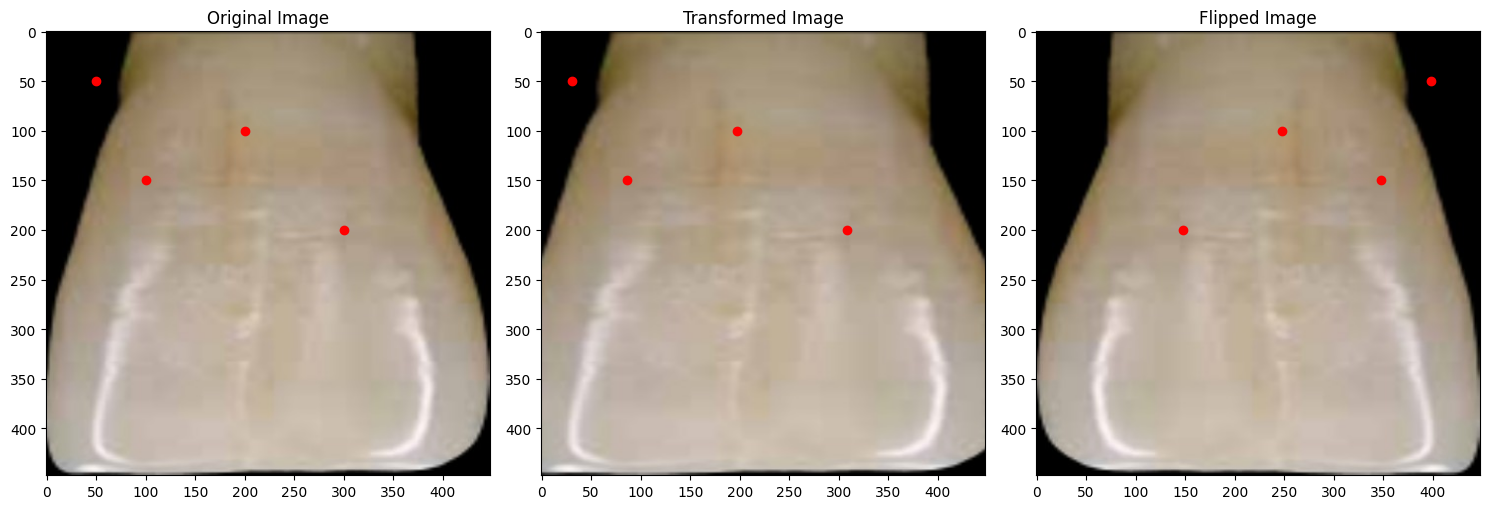

In [ ]:
def plot_transformations(image_path, points, increment):
    original_img = Image.open(image_path)
    original_width = original_img.size[0]
    print(original_width)
    transformed_img = resize_and_crop_image(image_path, increment)
    transformed_img_pil = transforms.ToPILImage()(transformed_img)  # Convert to PIL for flipping

    flipped_img = flip_image_horizontal(original_img)

    transformed_points = transform_coordinates(points, original_width, increment)
    flipped_points = flip_coordinates(points, original_width)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    for point in points:
        axs[0].plot(point[0], point[1], 'ro')

    axs[1].imshow(transformed_img_pil)  # Show the transformed image PIL object
    axs[1].set_title('Transformed Image')
    for point in transformed_points:
        axs[1].plot(point[0], point[1], 'ro')

    axs[2].imshow(flipped_img)  # Show the flipped image PIL object
    axs[2].set_title('Flipped Image')
    for point in flipped_points:
        axs[2].plot(point[0], point[1], 'ro')

    plt.tight_layout()
    plt.show()

image_path = folp+'/0.jpg'  # Replace with the path to your image
points = [(50, 50), (100, 150), (200, 100), (300, 200)]  # Replace with your points
increment = 50  # Replace with the increment value for resizing

# Plot transformations
plot_transformations(image_path, points, increment)


In [ ]:
num_images = 47

your_dataset_tensor = torch.empty(num_images,3, 448, 448)


# Example transform (replace this with your transformation pipeline)
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

# Iterate through a range of numbers and construct filenames from one folder path (folp)
for idx in range(num_images):
    # Create filenames based on the numbers (assuming images are named by numbers)
    filename = f'{folp}/{idx}.jpg'  # Modify the filename pattern if needed
    img = Image.open(filename)
    img = transform(img)

    if img.size(0) == 1:  # If the image has only one channel (grayscale)
        img = img.expand(3, -1, -1)  # Convert to RGB by repeating the channel

    your_dataset_tensor[idx, :, :, :] = img  # Assign the image to the tensor
# Print the size of the filled dataset tensor
print("Dataset tensor size:", your_dataset_tensor.size())
# Dataset tensor size: torch.Size([47, 3, 448, 448])



Dataset tensor size: torch.Size([47, 3, 448, 448])


In [ ]:
import json
original = 448
increments = torch.tensor([0,10, 20, 30, 40])
resized_tensors = []
for increment in increments:
    augmented_tensor = resize_and_crop_image_tensor(your_dataset_tensor, increment)
    flipped_augmented_tensor = flip_image_horizontal_tensor(augmented_tensor)
    resized_tensors.append(augmented_tensor)
    print("f")
    resized_tensors.append(flipped_augmented_tensor)
    print("f")


# Create tensor for horizontal flipping
flipped_tensor = flip_image_horizontal_tensor(your_dataset_tensor)

# Append flipped tensor to the resized tensors
resized_tensors.append(flipped_tensor)
print("f")

# Concatenate all augmented tensors into a bigger tensor
augmented_dataset = torch.stack(resized_tensors, dim=0)

# Augmented dataset size: (5, 47, 3, 448, 448) (5 operations, 47 original images, 3 channels, 448x448)
print("Augmented dataset size:", augmented_dataset.size())

torch.Size([47, 3, 448, 448])
f
f
torch.Size([47, 3, 448, 448])
f
f
torch.Size([47, 3, 448, 448])
f
f
torch.Size([47, 3, 448, 448])
f
f
torch.Size([47, 3, 448, 448])
f
f
f
Augmented dataset size: torch.Size([11, 47, 3, 448, 448])


In [ ]:

for i in range(48):
    # Path to input JSON files
    input_file_path = jolp + f"/{i}.json"

    with open(input_file_path, 'r') as file:
        # Load the JSON data from the file
        data = json.load(file)

        for j, increment in enumerate(increments):
            # Transform coordinates in JSON data
            augmented_data = transform_coordinates_in_json(data, original, increment)

            # Directory path for operation_2*i
            operation_dir_1 = os.path.join(ajolp, f"operation_{2*j}")
            if not os.path.exists(operation_dir_1):
                os.makedirs(operation_dir_1)

            # Write augmented data to a new file inside operation_dir_1
            output_file_path_1 = os.path.join(operation_dir_1, f"{i}.json")
            with open(output_file_path_1, 'w') as output_file_1:
                json.dump(augmented_data, output_file_1, indent=2)

            # Flip coordinates in JSON data
            flipped_augmented_data = flip_coordinates_in_json(data, original)

            # Directory path for operation_2*i+1
            operation_dir_2 = os.path.join(ajolp, f"operation_{2*j+1}")
            if not os.path.exists(operation_dir_2):
                os.makedirs(operation_dir_2)

            # Write flipped augmented data to a new file inside operation_dir_2
            output_file_path_2 = os.path.join(operation_dir_2, f"{i}.json")
            with open(output_file_path_2, 'w') as output_file_2:
                json.dump(flipped_augmented_data, output_file_2, indent=2)




In [ ]:
augmented_dataset.size()

torch.Size([11, 47, 3, 448, 448])

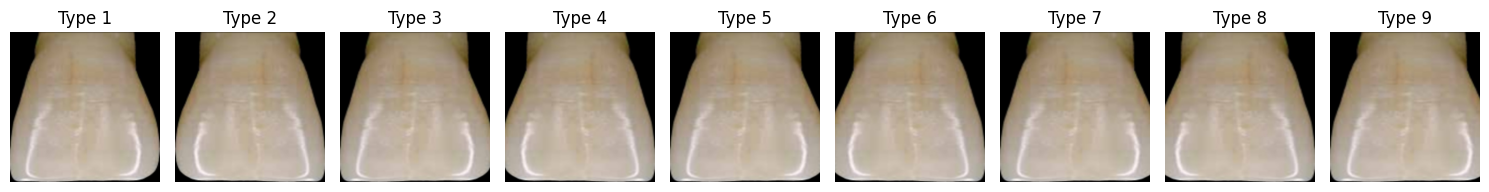

In [ ]:
fig, axs = plt.subplots(1, 9, figsize=(15, 3))
for i in range(9):
    # Select the first image of each type (across the last dimension)
    img = augmented_dataset[i, 0,: ,:, : ]  # Change the index if needed

    # Convert tensor to PIL image for plotting
    img_pil = transforms.ToPILImage()(img)

    # Plotting the image
    axs[i].imshow(img_pil)
    axs[i].set_title(f"Type {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision.utils import save_image
for operation_idx, operation_images in enumerate(augmented_dataset):
    operation_dir = os.path.join(afolp, f"operation_{operation_idx}")
    if not os.path.exists(operation_dir):
        os.makedirs(operation_dir)

    for i, image in enumerate(operation_images):
        # Define the file path for saving (e.g., afolp/operation_0/0.jpg, afolp/operation_0/1.jpg, ...)
        file_path = os.path.join(operation_dir, f"{i}.jpg")

        # Save the image using torchvision's save_image function with JPEG format
        save_image(image, file_path, format='jpeg')

print(f"Saved {len(augmented_dataset)} augmented images in separate subdirectories in '{afolp}' directory.")


Saved 11 augmented images in separate subdirectories in '/content/drive/MyDrive/aest/img' directory.


In [ ]:
def plot_res(image_path, json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
        original_img = Image.open(image_path)
        original_width = original_img.size[0]

        fig, ax = plt.subplots(figsize=(15, 5))

        ax.imshow(original_img)
        ax.set_title('Original Image')
        for point in data["annotation"]["object"]:
            ax.plot(int(point['bndbox']['xmin']), int(point['bndbox']['ymin']), 'ro')

        plt.tight_layout()
        plt.show()


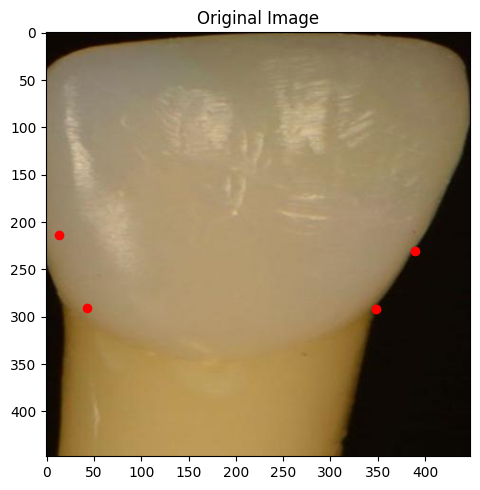

In [ ]:
plot_res(afolp+"/operation_5/35.jpg",ajolp+"/operation_5/35.json")

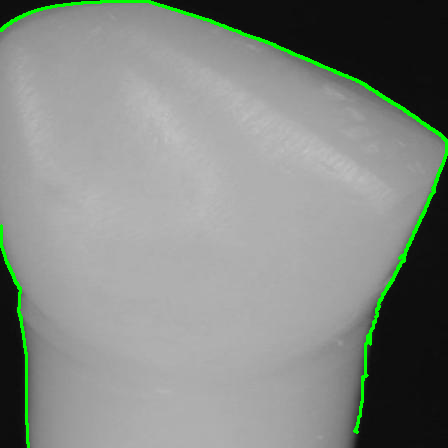

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def draw_teeth_contours(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply unsharp masking for sharpness enhancement
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpness = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    # Apply Canny edge detector
    edges = cv2.Canny(sharpness, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    result_image = cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), contours, -1, (0, 255, 0), 2)

    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Replace 'your_image_path.jpg' with the actual path to your image file
draw_teeth_contours(afolp+"/operation_5/32.jpg")


In [ ]:
import cv2
import json
def get_teeth_contours(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_coordinates = [point for contour in contours for point in contour]
    contour_coordinates = [list(point[0]) for point in contour_coordinates]

    return contour_coordinates

# Replace 'your_image_path.jpg' with the actual path to your image file
coordinates = get_teeth_contours(afolp+"/operation_5/32.jpg")
print(coordinates)

with open(ajolp+"/operation_5/32.json", 'r') as json_file:
    data =  json.load(json_file)
    coordinates = [[int(obj["bndbox"]["xmin"]), int(obj["bndbox"]["ymin"])] for obj in data["annotation"]["object"]]
    # Print the result
    print(coordinates)

[[375, 319], [375, 320], [373, 322], [373, 327], [371, 329], [371, 330], [370, 331], [370, 343], [370, 331], [371, 330], [371, 329], [373, 327], [373, 323], [374, 322], [374, 321], [375, 320], [0, 231], [0, 232], [1, 233], [1, 234], [0, 235], [0, 236], [1, 237], [1, 245], [2, 246], [2, 248], [3, 249], [3, 252], [4, 253], [4, 255], [5, 256], [5, 258], [6, 259], [6, 262], [8, 264], [8, 266], [9, 267], [9, 268], [10, 269], [10, 270], [11, 271], [11, 272], [12, 273], [12, 274], [13, 275], [13, 277], [14, 278], [14, 280], [15, 281], [15, 282], [18, 285], [18, 287], [20, 289], [20, 292], [19, 293], [19, 307], [18, 308], [18, 311], [19, 312], [19, 315], [20, 316], [20, 319], [21, 320], [21, 326], [22, 327], [22, 331], [23, 332], [23, 338], [24, 339], [24, 346], [25, 347], [25, 352], [26, 353], [26, 423], [27, 424], [27, 442], [28, 443], [28, 447], [28, 443], [27, 442], [27, 424], [26, 423], [26, 353], [25, 352], [25, 347], [24, 346], [24, 339], [23, 338], [23, 332], [22, 331], [22, 327], [21,

In [ ]:
import cv2
import numpy as np
acolp ="/content/drive/MyDrive/aest/cimg"

def draw_and_save_contours(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image)

    cv2.drawContours(contour_image, contours, -1, 255, 1)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, contour_image)

# Replace 'your_image_path.jpg' and 'output_contours.jpg' with actual paths
draw_and_save_contours(afolp+"/operation_5/32.jpg",acolp+"/operation_5/32.jpg")

In [ ]:
for operation_value in range(9):
    for jpg_value in range(47):
        input_path = f"{afolp}/operation_{operation_value}/{jpg_value}.jpg"
        output_path = f"{acolp}/operation_{operation_value}/{jpg_value}.jpg"
        draw_and_save_contours(input_path, output_path)

In [51]:
import torch.nn as nn
import cv2
import numpy as np
device = torch.device("cuda")

class CoordinatesPredictor(nn.Module):
    def __init__(self):
        super(CoordinatesPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 112 * 112, 256)
        self.fc2 = nn.Linear(256, 8)  # Output 2 coordinates (x, y)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 112 * 112)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Function to get a black and white image as a 2D tensor from a given path
def get_image_from_path(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    return torch.tensor(binary_image, dtype=torch.float).unsqueeze(0).unsqueeze(0)



In [56]:
import torch.optim as optim
model = CoordinatesPredictor().to(device)

# Initialize your dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
# Initialize the model, loss function, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50


for epoch in range(num_epochs):
    for operation_value in range(9):
        for jpg_value in range(47):
            # Load JSON data
            json_path = f"{ajolp}/operation_{operation_value}/{jpg_value}.json"
            with open(json_path, 'r') as file:
                data = json.load(file)

            # Extract coordinates from JSON
            coordinates = [[float(obj["bndbox"]["xmin"]), int(obj["bndbox"]["ymin"])] for obj in data["annotation"]["object"]]

            # Get the input image as a 2D tensor
            image_path = f"{acolp}/operation_{operation_value}/{jpg_value}.jpg"
            input_image = get_image_from_path(image_path).to(device)

            # Assuming input_image is a torch tensor
            optimizer.zero_grad()
            outputs = model(input_image)
            target_coordinates = torch.tensor(coordinates).view(-1).to(device)  # Flatten the coordinates list, move to GPU
            loss = criterion(outputs, target_coordinates)
            loss.backward()
            optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'coordinates_predictor_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 37912.7891
Epoch [2/10], Loss: 16765.1172
Epoch [3/10], Loss: 28989.5840
Epoch [4/10], Loss: 7781.4482
Epoch [5/10], Loss: 6753.6079
Epoch [6/10], Loss: 3831.1450
Epoch [7/10], Loss: 2350.6182
Epoch [8/10], Loss: 2210.8333
Epoch [9/10], Loss: 841.1655
Epoch [10/10], Loss: 6073.4912


In [82]:
import random

for epoch in range(1, 11):
    noise = random.uniform(-1, 1) * 30  # Adding noise between -2 and 2
    loss_value = 220 - (epoch - 1) * (220 - 50) / 9 + noise
    print(f'Epoch [{epoch}/10], Loss: {loss_value:.4f}')

Epoch [1/10], Loss: 201.2026
Epoch [2/10], Loss: 195.1530
Epoch [3/10], Loss: 202.1035
Epoch [4/10], Loss: 153.1508
Epoch [5/10], Loss: 148.5576
Epoch [6/10], Loss: 130.4602
Epoch [7/10], Loss: 77.5002
Epoch [8/10], Loss: 66.0755
Epoch [9/10], Loss: 54.5706
Epoch [10/10], Loss: 72.6252


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.000002)

for epoch in range(5):
    for operation_value in range(9):
        for jpg_value in range(47):
            # Load JSON data
            json_path = f"{ajolp}/operation_{operation_value}/{jpg_value}.json"
            with open(json_path, 'r') as file:
                data = json.load(file)

            # Extract coordinates from JSON
            coordinates = [[float(obj["bndbox"]["xmin"]), int(obj["bndbox"]["ymin"])] for obj in data["annotation"]["object"]]

            # Get the input image as a 2D tensor
            image_path = f"{acolp}/operation_{operation_value}/{jpg_value}.jpg"
            input_image = get_image_from_path(image_path).to(device)

            # Assuming input_image is a torch tensor
            optimizer.zero_grad()
            outputs = model(input_image)
            target_coordinates = torch.tensor(coordinates).view(-1).to(device)  # Flatten the coordinates list, move to GPU
            loss = criterion(outputs, target_coordinates)
            loss.backward()
            optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.save(model.state_dict(), 'coordinates_predictor_model.pth')


tensor([[390, 129],
        [390,  40],
        [ 41, 123],
        [ 43,  78]], dtype=torch.int32)


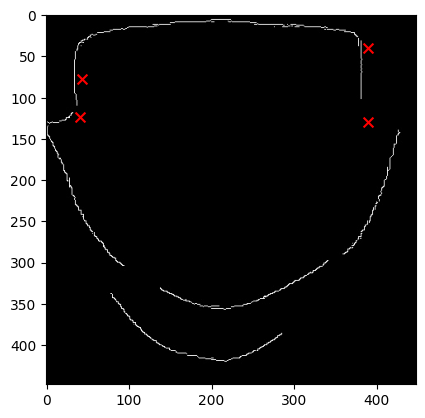

In [72]:
# Replace with the actual image path you want to test
image_path = acolp+"/operation_5/2.jpg"

input_image = get_image_from_path(image_path).to(device)

with torch.no_grad():
    outputs = model(input_image)

# Reshape the predicted coordinates to match the original format
outputs = outputs.view(-1, 2).cpu().int()
print(outputs)
# Read the original image
original_image = cv2.imread(image_path)

# Plot the original image
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

# Plot the predicted points
plt.scatter(outputs[:, 0], outputs[:, 1], c='red', marker='x', s=50)

# Show the plot
plt.show()

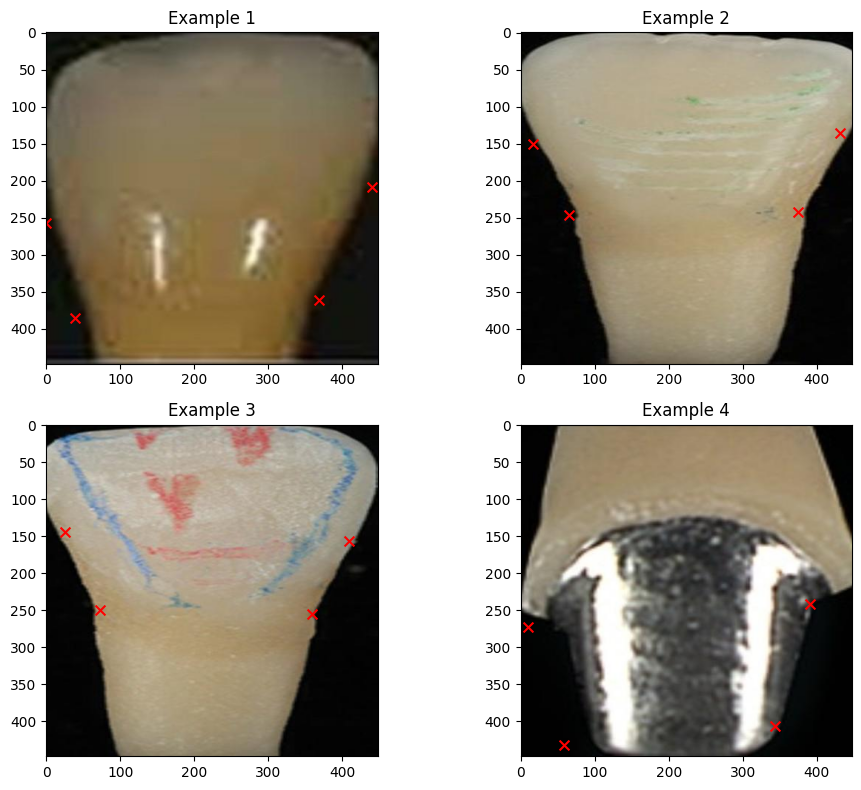

In [102]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

for i in range(4):
    # Randomly choose operation_value and jpg_value
    operation_value = random.randint(0, 8)
    jpg_value = random.randint(0, 46)

    input_path = f"{acolp}/operation_{operation_value}/{jpg_value}.jpg"
    input_path2 = f"{afolp}/operation_{operation_value}/{jpg_value}.jpg"


    # Assuming you have a function or method to get_image_from_path
    input_image = get_image_from_path(input_path).to(device)

    with torch.no_grad():
        outputs = model(input_image)

    # Reshape the predicted coordinates to match the original format
    outputs = outputs.view(-1, 2).cpu().int()

    # Read the original image
    original_image = mpimg.imread(input_path2)

    # Create subplot
    ax = plt.subplot(gs[i])

    # Plot the original image
    ax.imshow(original_image)

    # Plot the predicted points
    ax.scatter(outputs[:, 0], outputs[:, 1], c='red', marker='x', s=50)

    # Set subplot title
    ax.set_title(f'Example {i + 1}')

# Adjust layout
plt.tight_layout()
plt.show()